# Add imports

In [35]:
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array

from matplotlib import pyplot as plt

import numpy as np

# 1. Load dataset

In [36]:
data_dir = "dataset"

img_size = (224, 224)
batch_size = 32

## 1.1. Split dataset into training and validation

In [37]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 4032 files belonging to 9 classes.
Using 3226 files for training.


In [38]:
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

Found 4032 files belonging to 9 classes.
Using 806 files for validation.


In [39]:
class_names = train_ds.class_names
num_classes = len(class_names)

## 1.2. Prefetching to improve performance

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 2. Data Augmentation

In [41]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# 3. Load Pre-trained MobileNetV2

In [42]:
base_model = MobileNetV2(input_shape=img_size + (3,),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False

# 4. Build Model

In [43]:
inputs = tf.keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # preprocess for MobileNetV2

x = base_model(x, training=False)  # no BN updates
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # helps prevent overfitting
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = models.Model(inputs, outputs)

# 5. Compile

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 6. Train

In [45]:
# add early stopping for when val_loss does not improve for a set number of epoch
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [46]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    callbacks=[early_stopping])

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.1795 - loss: 2.3336 - val_accuracy: 0.4132 - val_loss: 1.6791
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3909 - loss: 1.6975 - val_accuracy: 0.6141 - val_loss: 1.2083
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5471 - loss: 1.3433 - val_accuracy: 0.7072 - val_loss: 0.9285
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6212 - loss: 1.1055 - val_accuracy: 0.7618 - val_loss: 0.7771
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6804 - loss: 0.9649 - val_accuracy: 0.8002 - val_loss: 0.6632
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7219 - loss: 0.8461 - val_accuracy: 0.8213 - val_loss: 0.5939
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7427 - loss: 0.7681 - val_accuracy: 0.8337 - val_loss: 0.5434
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7533 - loss: 0.7246 - val_accu

# 7. Fine-tune

In [47]:
base_model.trainable = True
for layer in base_model.layers[:]:  # freeze all but last 40 layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=30,
                         callbacks=[early_stopping])

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8797 - loss: 0.3573 - val_accuracy: 0.9057 - val_loss: 0.2786
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8807 - loss: 0.3521 - val_accuracy: 0.9032 - val_loss: 0.2776
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8785 - loss: 0.3552 - val_accuracy: 0.9032 - val_loss: 0.2778
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8831 - loss: 0.3458 - val_accuracy: 0.9032 - val_loss: 0.2776
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8816 - loss: 0.3508 - val_accuracy: 0.9045 - val_loss: 0.2773
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8872 - loss: 0.3391 - val_accuracy: 0.9045 - val_loss: 0.2770
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8859 - loss: 0.3381 - val_accuracy: 0.9045 - val_loss: 0.2769
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8859 - loss: 0.3329 - val_accu

# Show graph

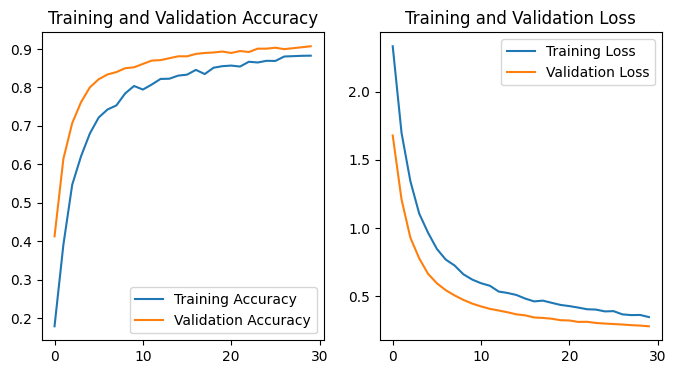

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Test image

In [49]:

def predict_single_image(img_path, model, class_names, top_k=3):
    # load and prepare image (do NOT call preprocess_input here because the model already does it)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)            # shape (224,224,3)
    img_array = np.expand_dims(img_array, axis=0)  # shape (1,224,224,3)

    preds = model.predict(img_array)               # model will preprocess internally
    probs = preds[0]
    top_idx = np.argsort(probs)[-top_k:][::-1]
    return [(class_names[i], float(probs[i])) for i in top_idx]


In [ ]:
img_path = "test/paper_bag/paper_bag.webp"
img_vis = image.load_img(img_path, target_size=(224,224))
plt.imshow(img_vis); plt.axis('off'); plt.title("Test image"); plt.show()

print("Top predictions:", predict_single_image(img_path, model, class_names, top_k=3))

FileNotFoundError: [Errno 2] No such file or directory: 'test/plastic_bag2.jpg'